<a href="https://colab.research.google.com/github/VitalyGladyshev/gb_pytorch/blob/main/HW_03_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ДЗ 3 Pytorch

## Задание 1

Как было сказано ранее, GAN обучается воспроизводить реальные данные. Поэтому Вам предлагается обучить генератор создавать точки, которые будут лежать на графике функции $y = \frac{sin(x)}{x} - \frac{x}{10}$. При выполненинии данного задания структура GAN остается той же, но Вам нужно:
 * Сгенерировать настоящие данные
 * Изменить архитектуру дискриминатора и генератора
 * Наличие графиков обязательно

In [1]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

In [8]:
x = np.linspace(-15, 15, 1001)

In [464]:
if 0 in x:
    print("Есть 0")

Есть 0


In [465]:
def func_y(x):    
    if 0 in x:
        x[x == 0] = 0.00001
    return np.sin(x)/x - x/10 

In [466]:
y = func_y(x)

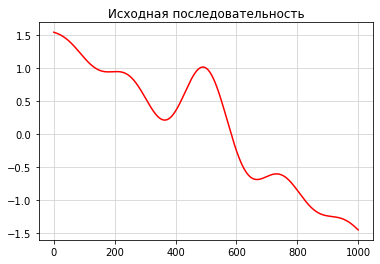

In [467]:
plt.plot(y, 'r')

plt.grid(color="lightgrey")
plt.title('Исходная последовательность' )
plt.show()

In [468]:
class Inc_Dataset(Dataset):
    def __init__(self, b_border, u_border, point_number):
        x = np.linspace(b_border, u_border, point_number)
        if 0 in x:
            x[x == 0] = 0.00001
        self.data = x
        self.labels = np.sin(x)/x - x/10


    def __len__(self):
        return len(self.data) 
    
    
    def __getitem__(self, idx):
        item = self.data[idx]
        label = self.labels[idx]
        return (item, label)

In [469]:
dataset = Inc_Dataset(-15, 15, 1001)

In [470]:
split_train_part = 0.75
batch_size = 16

real_data_dataset, test_dataset = torch.utils.data.random_split(dataset, 
                                                            [int(split_train_part*dataset.data.shape[0]), 
                                                             dataset.data.shape[0] - int(split_train_part*dataset.data.shape[0])])
real_data_loader = DataLoader(real_data_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False)

In [471]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


### Генератор

In [472]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 1)
        # self.sigm = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        # self.sph = nn.Softplus()

    def forward(self, x):
        # print("X размеры in: %s\n" % (x.shape,))
        x = self.tanh(self.fc1(x))
        # print("X размеры in: %s\n" % (x.shape,))
        x = self.tanh(self.fc2(x))
        # x = self.tanh(self.fc3(x))
        x = self.fc4(x)
        # print("X размеры in: %s\n" % (x.shape,))
        return x

### Дискриминатор 

In [473]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 128)
        self.fc2 = nn.Linear(128, 128)
        # self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 1)
        self.sigm = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        # self.sfm = nn.Softmax()

    def forward(self, x):
        # print("X размеры d in: %s\n" % (x.shape,))
        x = self.relu(self.fc1(x))
        # print("X размеры fc1 sigm in: %s\n" % (x.shape,))
        x = self.relu(self.fc2(x))
        # x = self.relu(self.fc3(x))
        x = self.sigm(self.fc4(x))
        return x

### Инициализация

In [474]:
n_epochs = 1000
lr = 0.0001   # 0.0005

b1 = 0.5
b2 = 0.999

sample_interval = 50

In [475]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))   # torch.optim.SGD(generator.parameters(), lr=lr, momentum=0.9)   # 
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))   # torch.optim.SGD(discriminator.parameters(), lr=lr, momentum=0.9)   # 

adversarial_loss = torch.nn.BCELoss()   # nn.CrossEntropyLoss() 

In [476]:
d_loss_history = []
g_loss_history = []

In [477]:
idx = torch.randperm(16)
idx

tensor([ 5,  0, 12, 10,  1, 11,  6, 15,  2, 14, 13,  7,  3,  4,  8,  9])

In [478]:
for epoch in range(1):
    for i, (number, labels) in enumerate(real_data_loader):

##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########

        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        real_number = Variable(number.type(torch.FloatTensor)).to(device)

        #генерация шума
        idx = torch.randperm(batch_size)
        z = Variable(number[idx].type(torch.FloatTensor)).to(device)

        print(f"real_number: {real_number}")
        # print(f"{z.shape}")
        print(f"z: {z.view(16, 1)}")
        print(f"{z.view(16, 1).shape}")
        # print(f"z: {z}")
        # print(f"real_number + z: {real_number + z}")
        print(f"valid.shape: {valid.shape}")
        print(f"fake.shape: {fake.shape}")

        break
    break

real_number: tensor([  3.8700,   1.2600,  -2.8500,   7.2300,  -1.9800,  13.9800,   7.2900,
         -7.6500, -10.0200, -12.0900,   6.9300,   2.2800,   6.4200,  -6.5700,
          0.7800,   2.4600])
z: tensor([[  2.2800],
        [ -2.8500],
        [  6.9300],
        [  7.2900],
        [ -1.9800],
        [  6.4200],
        [-10.0200],
        [  0.7800],
        [  7.2300],
        [  2.4600],
        [ 13.9800],
        [ -6.5700],
        [ -7.6500],
        [-12.0900],
        [  3.8700],
        [  1.2600]])
torch.Size([16, 1])
valid.shape: torch.Size([16, 1])
fake.shape: torch.Size([16, 1])


[Epoch 498/500] [Batch 44/47] [D loss: 0.666507] [G loss: 0.718898]


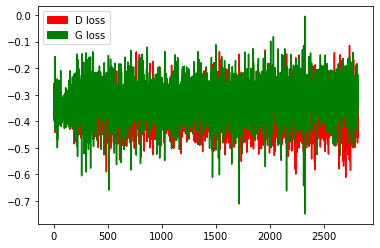

In [519]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')

g_loss_p = 1000
ep_loss = 0
n_epochs = 500

for epoch in range(n_epochs):
    for i, (number, labels) in enumerate(real_data_loader):

##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########

        valid = Variable(torch.FloatTensor(len(number), 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(len(labels), 1).fill_(0.0), requires_grad=False).to(device)

        real_numbers = Variable(number.type(torch.FloatTensor)).to(device)

######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        idx = torch.randperm(len(number))
        z = Variable(number[idx].type(torch.FloatTensor)).to(device)

        gen_numbers = generator(z.view(len(z), 1))

        validity = discriminator(gen_numbers)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()

        if g_loss < g_loss_p:
            torch.save(generator.state_dict(), "series_gan_loss_min.pth")
            g_loss_p = g_loss
            ep_loss = epoch

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator(labels.view(len(labels), 1).type(torch.FloatTensor).to(device))
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(gen_numbers.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############

        batches_done = epoch * len(real_data_loader) + i
    
        if batches_done % sample_interval == 0:
            plt.clf()
            
            display.clear_output(wait=False)
            # sample_image(gen_imgs)
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data_loader), d_loss.item(), g_loss.item()) ) 
            
            # display.display(plt.gcf())

            d_loss_history.append(d_loss)
            g_loss_history.append(g_loss)

            plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
            plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
            plt.legend(handles=[red_patch, green_patch])
            plt.show()

In [520]:
torch.save(generator.state_dict(), "series_gan.pth")

In [521]:
generator_r = Generator().to(device)
generator_r.load_state_dict(torch.load("series_gan_loss_min.pth"))

<All keys matched successfully>

In [522]:
x =  np.linspace(-15, 15, 50)
xt = torch.from_numpy(x).type(torch.FloatTensor).to(device)
xt.type()

'torch.FloatTensor'

In [523]:
gen_numbers = generator_r(xt.view(len(x), 1))

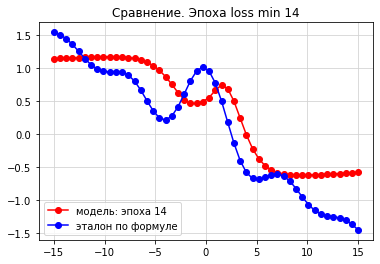

In [524]:
plt.plot(x, gen_numbers.detach().cpu().numpy(), 'ro-', label=f"модель: эпоха {ep_loss}")
plt.plot(x, func_y(x), 'bo-', label=f"эталон по формуле")

plt.legend(loc="lower left")
plt.grid(color="lightgrey")
plt.title(f'Сравнение. Эпоха loss min {ep_loss}' )
plt.show()

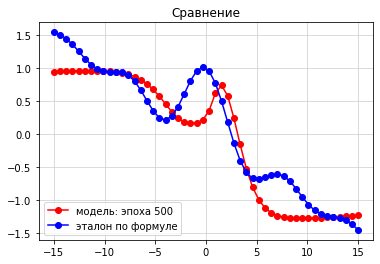

In [525]:
generator_f = Generator().to(device)
generator_f.load_state_dict(torch.load("series_gan.pth"))

gen_numbers_f = generator_f(xt.view(len(x), 1))

plt.plot(x, gen_numbers_f.detach().cpu().numpy(), 'ro-', label=f"модель: эпоха {n_epochs}")
plt.plot(x, func_y(x), 'bo-', label=f"эталон по формуле")

plt.legend(loc="lower left")
plt.grid(color="lightgrey")
plt.title('Сравнение' )
plt.show()

### Тестовый dataset


In [526]:
x_test = []
y_test = []

for x, y in test_loader:
    x_test.append(x), y_test.append(y)

In [527]:
xt = torch.FloatTensor(x_test).to(device)
gen_numbers_t = generator_f(xt.view(len(x_test), 1))

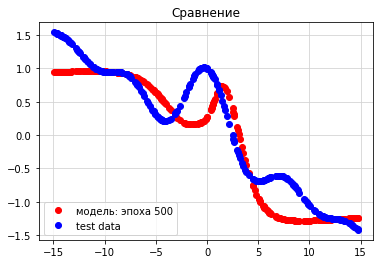

In [528]:
plt.plot(x_test, gen_numbers_t.detach().cpu().numpy(), 'ro', label=f"модель: эпоха {n_epochs}")
plt.plot(x_test, y_test, 'bo', label=f"test data")

plt.legend(loc="lower left")
plt.grid(color="lightgrey")
plt.title('Сравнение' )
plt.show()

## Задание 2

Изменить используемые модели генератора и дискриминатора, с помощью сверточных слоев. Идея: https://arxiv.org/abs/1511.06434 Датасет можно использовать так же MNIST.

In [326]:
thr_num = 8
batch_sz = 4

In [327]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])

In [328]:
mnist_train = datasets.MNIST(root='./MNIST/train', 
                                         train=True, 
                                         download=True, 
                                         transform=transform)
mnist_train_loader = torch.utils.data.DataLoader(mnist_train,
                                                 batch_size=batch_sz,
                                                 shuffle=True,
                                                 num_workers=thr_num)

mnist_test = datasets.MNIST(root='./MNIST/test', 
                                        train=False, 
                                        download=True, 
                                        transform=transform)
mnist_test_loader = torch.utils.data.DataLoader(mnist_test,
                                                batch_size=batch_sz,
                                                shuffle=False,
                                                num_workers=thr_num)

In [329]:
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images размеры view: torch.Size([4, 1, 28, 28])

imgs размеры view: torch.Size([3, 32, 122])

GroundTruth:
        3        9        6        3


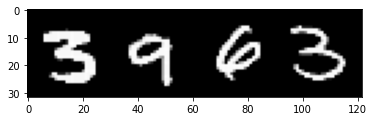

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images размеры view: torch.Size([4, 1, 28, 28])

imgs размеры view: torch.Size([3, 32, 122])

GroundTruth:
        2        6        9        6


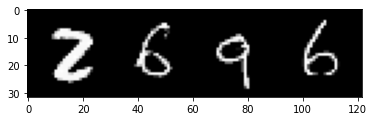

In [330]:
data_iter = iter(mnist_train_loader)
# [data_iter.next() for i in range(0)]

for i in range(2):
    images, labels = data_iter.next()

    print("images размеры view: %s\n" % (images.shape, ))
    
    imgs = make_grid(images)
    print("imgs размеры view: %s\n" % (imgs.shape,))
    print('GroundTruth:\n', ' '.join('%8s' % classes[labels[j]] for j in range(batch_sz)))
    plt.imshow(imgs.permute(1, 2, 0).numpy())
    plt.show()

### Генератор

In [356]:
class Generator(nn.Module):
    def __init__(self, cnn_filt_num=8, kern_size=5, func_act='relu', in_shape=28, nn_prn=False):
        super(Generator, self).__init__()

        self.nn_prn = nn_prn
        
        self.relu = nn.ReLU()

        # self.conv1 = nn.Conv2d(1, cnn_filt_num, kernel_size=kern_size, stride=1, padding=(2, 2))
        # self.conv2 = nn.Conv2d(cnn_filt_num, cnn_filt_num*2, kernel_size=kern_size, stride=1, padding=(2, 2))
        # cnn_filt_num *= 2
        
        # self.fs_size = cnn_filt_num * in_shape ** 2
        # fs_sz = self.fs_size
        # self.fc_dec1 = nn.Linear(fs_sz, in_shape ** 2)

        # keras.Input(shape=(latent_dim,)),
        # # строим размер входного вектора 7x7x128 map
        # layers.Dense(7 * 7 * 128),
        # layers.LeakyReLU(alpha=0.2),
        # layers.Reshape((7, 7, 128)),
        # layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        # layers.LeakyReLU(alpha=0.2),
        # layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        # layers.LeakyReLU(alpha=0.2),
        # layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),

        self.fc_dec1 = nn.Linear(16, 7*7*16)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.conv2_transp_1 = nn.ConvTranspose2d(1, 16, kernel_size=4, stride=(2, 2), padding=(1, 1)) #, output_padding=1)
        nn.init.normal_(self.conv2_transp_1.weight.data, 0.0, 0.02)
        self.conv2_transp_2 = nn.ConvTranspose2d(16, 16, kernel_size=4, stride=(2, 2), padding=(1, 1)) #, output_padding=1)
        nn.init.normal_(self.conv2_transp_2.weight.data, 0.0, 0.02)
        self.conv2_1 = nn.Conv2d(16, 1, kernel_size=7) # , stride=1, padding=(2, 2)
        nn.init.normal_(self.conv2_1.weight.data, 0.0, 0.02)
        self.fc_dec2 = nn.Linear(16*22*22, 784)
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        if self.nn_prn:
            print("Генератор\n")
            print("\tразмеры income: %s\n" % (x.shape,))
        x = x.view(-1, 16)
        if self.nn_prn:
            print("\tразмеры x.view: %s\n" % (x.shape,))
        x = self.leaky_relu(self.fc_dec1(x))
        if self.nn_prn:
            print("\tразмеры fc_dec1, leaky_relu: %s\n" % (x.shape,))
        x = x.view(-1, 1, 7, 7)
        if self.nn_prn:
            print("\tразмеры x.view: %s\n" % (x.shape,))
        x = self.leaky_relu(self.conv2_transp_1(x))
        if self.nn_prn:
            print("\tразмеры conv2_transp_1, leaky_relu: %s\n" % (x.shape,))
        x = self.leaky_relu(self.conv2_transp_2(x))
        if self.nn_prn:
            print("\tразмеры conv2_transp_2, leaky_relu: %s\n" % (x.shape,))
        x = self.sigm(self.conv2_1(x))
        if self.nn_prn:
            print("\tразмеры conv2_1, sigm: %s\n" % (x.shape,))
        x = x.view(-1, 16*22*22)
        if self.nn_prn:
            print("\tразмеры x.view: %s\n" % (x.shape,))
        x = self.relu(self.fc_dec2(x))
        if self.nn_prn:
            print("\tразмеры fc_dec2: %s\n" % (x.shape,))
        x = x.view(1, 28, 28)
        if self.nn_prn:
            print("\tразмеры x.view: %s\n" % (x.shape,))
            self.nn_prn = False
        return x

### Дискриминатор 

In [357]:
class Discriminator(nn.Module):
    def __init__(self, cnn_filt_num=16, kern_size=5, func_act='relu', in_shape=28, nn_prn=False):
        super(Discriminator, self).__init__()

        self.nn_prn = nn_prn
        
        self.relu = nn.ReLU()
        self.sigm = nn.Sigmoid()

        self.conv1 = nn.Conv2d(1, cnn_filt_num, kernel_size=kern_size, stride=1, padding=(2, 2))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(cnn_filt_num, cnn_filt_num*2, kernel_size=kern_size, stride=1, padding=(2, 2))
        cnn_filt_num *= 2
        
        self.fs_size = cnn_filt_num * (in_shape//2**2) ** 2
        fs_sz = self.fs_size
        
        self.fc_dec1 = nn.Linear(fs_sz, fs_sz//4)   # fs_sz*3//4
        fs_sz=fs_sz//4   # *3//4
        self.fc_out = nn.Linear(fs_sz, 1)

    def forward(self, x):
        if self.nn_prn:
            print("Дискриминатор\n")
            print("\tразмеры income: %s\n" % (x.shape,))
        x = x.view(1, 1, 28, 28)
        if self.nn_prn:
            print("\tразмеры x.view: %s\n" % (x.shape,))
        x = self.pool(self.relu(self.conv1(x)))
        if self.nn_prn:
            print("\tразмеры conv1, pool: %s\n" % (x.shape,))
        x = self.pool(self.relu(self.conv2(x)))
        if self.nn_prn:
            print("\tразмеры conv2, pool: %s\n" % (x.shape,))

        x = x.view(-1, self.fs_size)
        if self.nn_prn:
            print("\tразмеры x.view: %s\n" % (x.shape,))
        x = self.relu(self.fc_dec1(x))
        if self.nn_prn:
            print("\tразмеры fc_dec1: %s\n" % (x.shape,))
        x = self.sigm(self.fc_out(x))
        if self.nn_prn:
            print("\tразмеры fc_out: %s\n" % (x.shape,))
            self.nn_prn = False
        return x

### Инициализация

In [358]:
n_epochs = 2   # 1500
lr = 0.001   # 0.0005

b1 = 0.5
b2 = 0.999

sample_interval = 50

In [359]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [360]:
batch_sz = 1
mnist_train = datasets.MNIST(root='./MNIST/train', 
                                         train=True, 
                                         download=True, 
                                         transform=transform)
mnist_train_loader = torch.utils.data.DataLoader(mnist_train,
                                                 batch_size=batch_sz,
                                                 shuffle=True,
                                                 num_workers=thr_num)

In [361]:
generator = Generator(nn_prn=True).to(device)
discriminator = Discriminator(nn_prn=True).to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)   # , betas=(b1, b2))   # torch.optim.SGD(generator.parameters(), lr=lr, momentum=0.9)   # 
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)   # , betas=(b1, b2))   # torch.optim.SGD(discriminator.parameters(), lr=lr, momentum=0.9)   # 

adversarial_loss = torch.nn.BCELoss()   # nn.CrossEntropyLoss() 

In [362]:
d_loss_history = []
g_loss_history = []

In [363]:
######## функция для вывода изображения ########
def sample_image(static_sample):
    npimg = make_grid(static_sample.data).cpu().numpy()
    fig, ax = plt.subplots(figsize=(4, 1))
    ax.imshow(np.transpose(npimg, (1,2,0)), interpolation="nearest")
    plt.show()

[Epoch 0/2] [Batch 16000/60000] [D loss: 0.000000] [G loss: 23.478685]


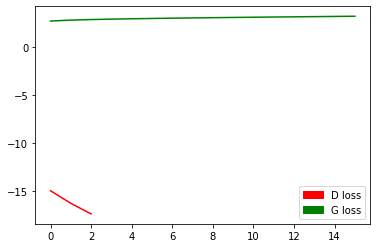

KeyboardInterrupt: ignored

In [364]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')

g_loss_p = 1000
ep_loss = 0

for epoch in range(n_epochs):
    for i, (number, labels) in enumerate(mnist_train_loader):

##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########

        valid = Variable(torch.FloatTensor(len(number), 1).fill_(1.0), requires_grad=False).to(device)
        fake = Variable(torch.FloatTensor(len(labels), 1).fill_(0.0), requires_grad=False).to(device)

        real_numbers = Variable(number.type(torch.FloatTensor)).to(device)

######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        z = Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_sz, 16)))).to(device)

        gen_numbers = generator(z)   # .view(len(z), 1)

        validity = discriminator(gen_numbers)
        g_loss = adversarial_loss(validity, valid)
        
        g_loss.backward()
        optimizer_G.step()

        if g_loss < g_loss_p:
            torch.save(generator.state_dict(), "series_gan_loss_min.pth")
            g_loss_p = g_loss
            ep_loss = epoch

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()

        real_pred = discriminator(real_numbers)
        d_real_loss = adversarial_loss(real_pred, valid)

        fake_pred = discriminator(gen_numbers.detach())
        d_fake_loss = adversarial_loss(fake_pred, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############

        batches_done = epoch * len(mnist_train_loader) + i
    
        if (i+1) % 1000 == 0:
            plt.clf()
            
            display.clear_output(wait=False)

            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i+1, len(mnist_train_loader), d_loss.item(), g_loss.item()) ) 
            # sample_image(gen_numbers)            
            # display.display(plt.gcf())

            d_loss_history.append(d_loss)
            g_loss_history.append(g_loss)

            plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
            plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
            plt.legend(handles=[red_patch, green_patch])
            plt.show()

In [ ]:
torch.save(generator.state_dict(), "series_gan.pth")

<Figure size 432x288 with 0 Axes>

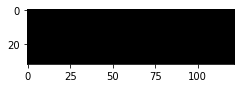

<Figure size 432x288 with 0 Axes>

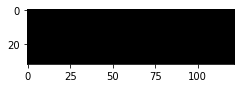

<Figure size 432x288 with 0 Axes>

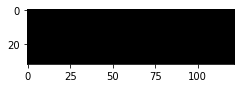

<Figure size 432x288 with 0 Axes>

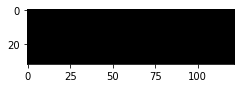

<Figure size 432x288 with 0 Axes>

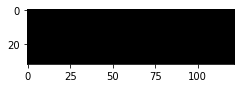

<Figure size 432x288 with 0 Axes>

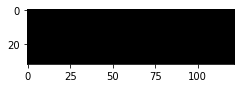

<Figure size 432x288 with 0 Axes>

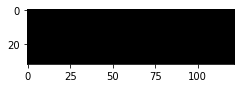

<Figure size 432x288 with 0 Axes>

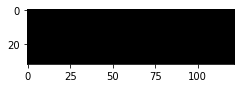

<Figure size 432x288 with 0 Axes>

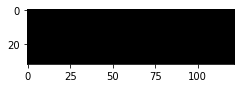

<Figure size 432x288 with 0 Axes>

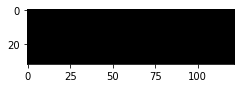

In [93]:
for it in range(10):
    z = Variable(torch.FloatTensor(np.random.normal(0, 1, (batch_sz, 784)))).to(device)

    gen_numbers = generator(z)

    plt.clf()

    # display.clear_output(wait=False)
    sample_image(gen_numbers)
    # display.display(plt.gcf())